# Region Growing

In [22]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [23]:
#function to implement region growing
def region_growing(image, seed, threshold):
    # Initialize the segmentation result
    segmented_image = np.zeros_like(image)
    height, width = image.shape

    # List of points to be checked
    check_points = [seed]

    # List of directions for 8-connected neighbors
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    while check_points:
        x, y = check_points.pop(0)

        # Avoid re-checking points
        if segmented_image[y, x] != 0:
            continue

        # Mark the current point as part of the region
        segmented_image[y, x] = 255

        # Check the neighbors
        for dx, dy in directions:
            nx, ny = x + dx, y + dy

            # Ensure the neighbor is within the image boundaries
            if 0 <= nx < width and 0 <= ny < height:
                # Calculate the intensity difference
                if abs(int(image[ny, nx]) - int(image[y, x])) < threshold:
                    # Add the neighbor to the list of points to be checked
                    check_points.append((nx, ny))

    return segmented_image

In [24]:
# Load the image
image = cv2.imread('white.jpg', cv2.IMREAD_GRAYSCALE)

In [25]:
# Define the seed point and threshold
seed_point = (100, 100)  # Example seed point
threshold_value = 10  # Example threshold value
# Apply region growing
segmented_result = region_growing(image, seed_point, threshold_value)

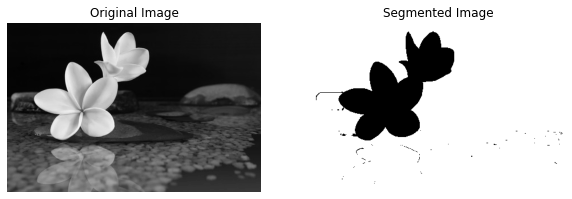

In [26]:
# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()

# Split and Merge

In [33]:
#import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [37]:
#function to implement split and merge operations
def split_and_merge(image, threshold):
    def split(image, x, y, w, h, threshold):
        # Base case: if the region is smaller than 1x1, return the region
        if w <= 1 or h <= 1:
            return [(x, y, w, h)]
        
        # Calculate the mean and standard deviation of the region
        region = image[y:y+h, x:x+w]
        mean, stddev = cv2.meanStdDev(region)
        
        # If the standard deviation is less than the threshold, return the region
        if stddev[0][0] < threshold:
            return [(x, y, w, h)]
        
        # Otherwise, split the region into four subregions
        half_w, half_h = w // 2, h // 2
        regions = []
        regions.extend(split(image, x, y, half_w, half_h, threshold))
        regions.extend(split(image, x + half_w, y, half_w, half_h, threshold))
        regions.extend(split(image, x, y + half_h, half_w, half_h, threshold))
        regions.extend(split(image, x + half_w, y + half_h, half_w, half_h, threshold))
        
        return regions
    def merge(regions, image, threshold):
        def find_neighbors(regions, region):
            neighbors = []
            x, y, w, h = region
            for (nx, ny, nw, nh) in regions:
                if (nx == x + w or nx + nw == x) and ny == y and nh == h:
                    neighbors.append((nx, ny, nw, nh))
                elif (ny == y + h or ny + nh == y) and nx == x and nw == w:
                    neighbors.append((nx, ny, nw, nh))
            return neighbors
        
        merged = np.zeros_like(image, dtype=np.uint8)
        for region in regions:
            x, y, w, h = region
            neighbors = find_neighbors(regions, region)
            region_mean = np.mean(image[y:y+h, x:x+w])
            merge_region = True
            for neighbor in neighbors:
                nx, ny, nw, nh = neighbor
                neighbor_mean = np.mean(image[ny:ny+nh, nx:nx+nw])
                if abs(region_mean - neighbor_mean) > threshold:
                    merge_region = False
                    break
            if merge_region:
                cv2.rectangle(merged, (x, y), (x+w, y+h), int(region_mean), cv2.FILLED)
        return merged
    # Split the image
    height, width = image.shape
    regions = split(image, 0, 0, width, height, threshold)

    # Merge the regions
    merged_image = merge(regions, image, threshold)
    
    return merged_image

In [38]:
# Load the image
image = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)

# Define the threshold
threshold_value = 10  # Example threshold value

# Apply region splitting and merging
segmented_result = split_and_merge(image, threshold_value)

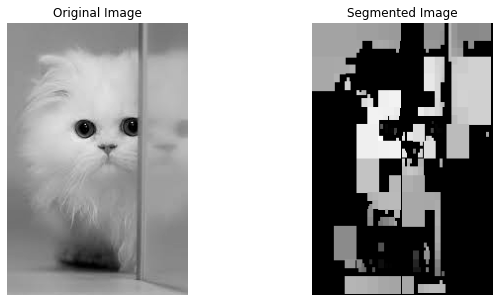

In [39]:
# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()

# Merging regions

In [45]:
#import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [46]:
#function to perform initial segmentation
def initial_segmentation(image, spatial_radius=21, color_radius=51):
    return cv2.pyrMeanShiftFiltering(image, sp=spatial_radius, sr=color_radius)

In [47]:
#function to find the neighbours and then merge the regions based on color similarity.
def merge_regions(image, labels, threshold):
    height, width = image.shape[:2]
    segmented_image = np.zeros_like(image)
    
    # Create a dictionary to store mean colors of regions
    mean_colors = {}
    
    for y in range(height):
        for x in range(width):
            label = labels[y, x]
            if label not in mean_colors:
                mean_colors[label] = []
            mean_colors[label].append(image[y, x])
    
    for label in mean_colors:
        mean_colors[label] = np.mean(mean_colors[label], axis=0)
    
    def find_neighbors(labels, label):
        neighbors = set()
        for y in range(height):
            for x in range(width):
                if labels[y, x] == label:
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            if 0 <= y+dy < height and 0 <= x+dx < width:
                                neighbor_label = labels[y+dy, x+dx]
                                if neighbor_label != label:
                                    neighbors.add(neighbor_label)
        return neighbors
    
    def merge(label, neighbors):
        region_color = mean_colors[label]
        for neighbor in neighbors:
            neighbor_color = mean_colors[neighbor]
            if np.linalg.norm(region_color - neighbor_color) < threshold:
                labels[labels == neighbor] = label
                mean_colors[label] = (mean_colors[label] + mean_colors[neighbor]) / 2
                del mean_colors[neighbor]
    
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        neighbors = find_neighbors(labels, label)
        merge(label, neighbors)
    
    for y in range(height):
        for x in range(width):
            segmented_image[y, x] = mean_colors[labels[y, x]]
    
    return segmented_image

In [49]:
# Load the image
image = cv2.imread('white.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [50]:
# Perform initial segmentation
initial_segmented = initial_segmentation(image)

# Convert the initial segmentation result to labels
_, labels = cv2.connectedComponents(cv2.cvtColor(initial_segmented, cv2.COLOR_RGB2GRAY).astype(np.uint8))

# Define the threshold for merging regions
threshold_value = 30  # Example threshold value

# Merge the regions
merged_result = merge_regions(image, labels, threshold_value)

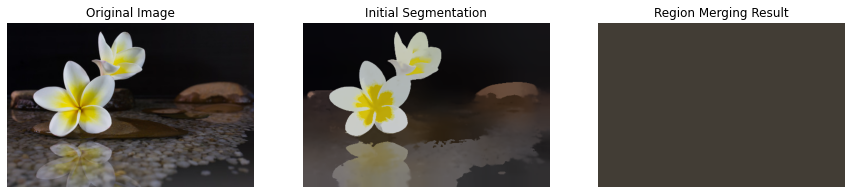

In [51]:
# Display the original, initial segmented, and final merged images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(initial_segmented)
plt.title('Initial Segmentation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(merged_result)
plt.title('Region Merging Result')
plt.axis('off')

plt.show()

# Split and Merge

In [67]:
#import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [68]:
#function to split the regions
def split(image, x, y, w, h, threshold):
    region = image[y:y+h, x:x+w]
    mean, stddev = cv2.meanStdDev(region)[:2]
    
    # If the region is homogeneous enough, return the region
    if stddev[0] < threshold:
        return [(x, y, w, h)]
    
    # If the region is too small to split, return the region
    if w <= 1 or h <= 1:
        return [(x, y, w, h)]
    
    # Otherwise, split the region into four subregions
    half_w, half_h = w // 2, h // 2
    regions = []
    regions.extend(split(image, x, y, half_w, half_h, threshold))
    regions.extend(split(image, x + half_w, y, half_w, half_h, threshold))
    regions.extend(split(image, x, y + half_h, half_w, half_h, threshold))
    regions.extend(split(image, x + half_w, y + half_h, half_w, half_h, threshold))
    
    return regions

In [69]:
#function to merge similar adjacent regions.
def merge(image, regions, threshold):
    labels = np.zeros((image.shape[0], image.shape[1]), np.int32)
    current_label = 1

    for region in regions:
        x, y, w, h = region
        labels[y:y+h, x:x+w] = current_label
        current_label += 1

    merged = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, current_label):
        mask = labels == i
        mean_color = cv2.mean(image, mask.astype(np.uint8))[:3]
        merged[mask] = mean_color

    return merged

In [70]:
#function to perform region splitting and merging
def split_and_merge(image, threshold):
    height, width = image.shape[:2]
    regions = split(image, 0, 0, width, height, threshold)
    merged_image = merge(image, regions, threshold)
    return merged_image

In [72]:
# Load the image
image = cv2.imread('drop.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [73]:
# Define the threshold for homogeneity
threshold_value = 10  # Example threshold value

# Apply region splitting and merging
segmented_result = split_and_merge(image, threshold_value)

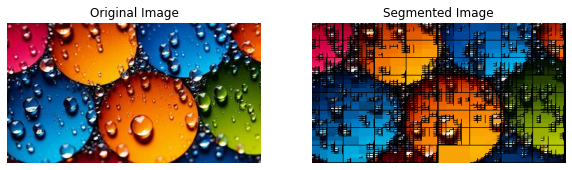

In [74]:
# Display the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_result)
plt.title('Segmented Image')
plt.axis('off')

plt.show()

# Region Growing

In [1]:
import cv2
from segmentation import Region_Growing
import pydicom
import os, sys, getopt

ModuleNotFoundError: No module named 'segmentation'